In [1]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [85]:
# CONTENT_FILENAME = "inputs/imperial.mp3"
# STYLE_FILENAME = "inputs/usa.mp3"
# fig1_name = "imperial_usa.png"

# CONTENT_FILENAME = "inputs/usa.mp3"
# STYLE_FILENAME = "inputs/imperial.mp3"
# fig1_name = "usa_imperial.png"

# CONTENT_FILENAME = "inputs/bach_violin.mp3"
# STYLE_FILENAME = "inputs/elgar_cello.mp3"
# fig1_name = "violin_cello.png"
# test_number = "cello_onto_violin_2cnn_2pool"

# CONTENT_FILENAME = "inputs/elgar_cello.mp3"
# STYLE_FILENAME = "inputs/bach_violin.mp3"
# fig1_name = "cello_violin.png"
# test_number = "violin_onto_cello_2cnn_2pool"

CONTENT_FILENAME = "inputs/bach_violin.mp3"
STYLE_FILENAME = "inputs/saxophone.mp3"
fig1_name = "violin_saxophone.png"
test_number = "sax_onto_violin_2cnn_2pool"

# CONTENT_FILENAME = "inputs/saxophone.mp3"
# STYLE_FILENAME = "inputs/bach_violin.mp3"
# fig1_name = "saxophone_violin.png"


fig2_name = "{}.png".format(test_number)
output_wav_name = "{}.wav".format(test_number)

In [86]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [87]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [88]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_CHANNELS = a_content.shape[0]
N_SAMPLES = a_content.shape[1]

a_style = a_style[:N_CHANNELS, :N_SAMPLES]  # Sync size of content and style audio
print(N_CHANNELS, N_SAMPLES)
# print(a_style.shape[0], a_style.shape[1])


(1025, 430)


### Visualize spectrograms for content and style tracks


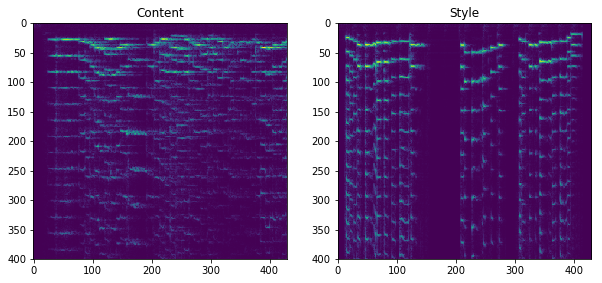

In [89]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:]) # Clipping images
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.savefig(fig1_name)
plt.show()

### Compute content and style feats¶


In [90]:
## Testing different filter sizes
N_FILTERS = 4096 #7000 #1000 
print("N samples: ", N_SAMPLES)
print("N channels: ", N_CHANNELS)
print("N filters: ", N_FILTERS)

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

## Testing diff filter size
# a_content_tf = np.ascontiguousarray(a_content)
# a_style_tf = np.ascontiguousarray(a_style)

## filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))

## Testing 2 conv layers
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
kernel2 = np.random.randn(1,11, N_FILTERS, N_FILTERS)*std

## Testing long filter with width 10
# kernel_width10 = np.random.randn(100, 1, N_CHANNELS, N_FILTERS)*std

g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1, N_SAMPLES,N_CHANNELS], name="x")
    print("X shape:", x.get_shape()) # SHAPE: (1, 1, 430, 1025)

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    kernel_tf2 = tf.constant(kernel2, name="kernel2", dtype='float32')
#     kernel_width10_tf = tf.constant(kernel_width10, name="kernel_width10", dtype='float32')

    # Conv 1
    conv1 = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv1")         # SHAPE: (1, 1, 420, 4096)      
    print("Post CNN 1 shape: ", conv1.get_shape())
    
    # Pool 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[1, 2], strides=2)
    print('Post Pool 1 shape:', pool1.get_shape())
    
    # Conv 2
    conv2 = tf.nn.conv2d(
        pool1,
        kernel_tf2,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv2")
    print("Post CNN 2 shape: ", conv2.get_shape())
    
    # Pool 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[1, 2], strides=2)

#     net = tf.nn.relu(conv1)
#     net = tf.nn.relu(conv2)
    
    net = tf.nn.relu(pool2)

#     conv = tf.nn.conv2d(
#         x,
#         kernel_width10_tf,
#         strides=[1, 1, 1, 1],
#         padding="VALID",
#         name="conv")         # SHAPE: (1, 1, 420, 4096)      
#     print("Post CNN shape: ", conv.get_shape())
#     net = tf.nn.relu(conv)
    
    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

('N samples: ', 430)
('N channels: ', 1025)
('N filters: ', 4096)
('X shape:', TensorShape([Dimension(1), Dimension(1), Dimension(430), Dimension(1025)]))
('Post CNN 1 shape: ', TensorShape([Dimension(1), Dimension(1), Dimension(420), Dimension(4096)]))
('Post Pool 1 shape:', TensorShape([Dimension(1), Dimension(1), Dimension(210), Dimension(4096)]))
('Post CNN 2 shape: ', TensorShape([Dimension(1), Dimension(1), Dimension(200), Dimension(4096)]))


### Optimize

In [91]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    kernel_tf2 = tf.constant(kernel2, name="kernel2", dtype='float32')
    
#     kernel_width10_tf = tf.constant(kernel_width10, name="kernel_width10", dtype='float32')

    conv1 = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv1")
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[1, 2], strides=2)

    ## Testing 2 conv layers
    conv2 = tf.nn.conv2d(
        pool1,
        kernel_tf2,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv2")

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[1, 2], strides=2)
    
#     net = tf.nn.relu(conv1)
#     net = tf.nn.relu(conv2)
    net = tf.nn.relu(pool1)

#     conv = tf.nn.conv2d(
#         x,
#         kernel_width10_tf,
#         strides=[1, 1, 1, 1],
#         padding="VALID",
#         name="conv")         # SHAPE: (1, 1, 420, 4096)
#     net = tf.nn.relu(conv)
    
    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print 'Final loss:', loss.eval()
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT
  Objective function value: 317.845795
  Number of iterations: 301
  Number of functions evaluations: 310
Final loss: 317.846


In [92]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/' + output_wav_name # TODO: Change this filename to not overwrite results
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

### Invert spectrogram and save the result

In [93]:
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

outputs/sax_onto_violin_2cnn_2pool.wav


### Visualize spectrograms

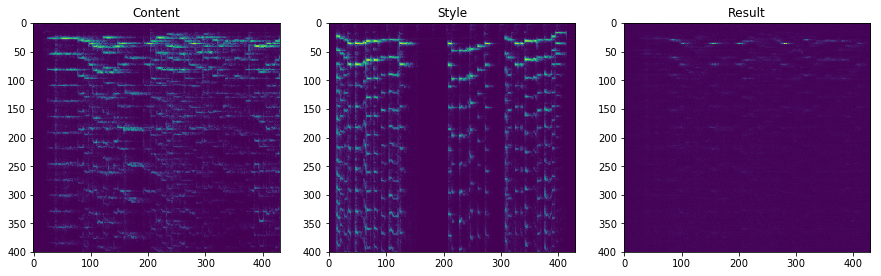

In [94]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.savefig(fig2_name)
plt.show()